In [1]:
import sys
sys.path.insert(0, '../../')

import os
import numpy as np
from tqdm import tqdm


import torch
from torch.utils import data
import torchvision.transforms as transform
from torch.nn.parallel.scatter_gather import gather

import encoding.utils as utils
from encoding.nn import SegmentationLosses, SyncBatchNorm
from encoding.parallel import DataParallelModel, DataParallelCriterion
from encoding_custom.datasets import get_segmentation_dataset, test_batchify_fn
from encoding.models import get_model, MultiEvalModule
from encoding_custom.models import get_segmentation_model
import json
from experiments.segmentation.option import Options
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
input_transform = transform.Compose([
    transform.ToTensor(),
    transform.Normalize([.485, .456, .406], [.229, .224, .225])])
    
testset = get_segmentation_dataset('mapillary', split='train', mode='train',
                                   transform=input_transform, root='/data/input/datasets/Mapillary_v1.1/',
                                   base_size = 1024, crop_size = 768)

BaseDataset: base_size 1024, crop_size 768


../../encoding_custom/datasets/__init__.py:56: EncodingDeprecationWarning: encoding.dataset.get_segmentation_dataset is now deprecated in favor of encoding.dataset.get_dataset.
  .format(old_name, new_name), EncodingDeprecationWarning)


In [3]:
testset[0]

(tensor([[[ 1.6495,  1.0159,  0.7933,  ...,  1.6667,  1.6838,  1.6667],
          [ 1.7523,  1.6667,  1.1872,  ...,  1.6667,  1.6667,  1.6667],
          [ 1.7009,  1.7523,  1.7352,  ...,  1.6667,  1.6667,  1.6667],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[ 2.0084,  1.3081,  1.0630,  ...,  2.0784,  2.0784,  2.0609],
          [ 2.1485,  2.0084,  1.5007,  ...,  2.0784,  2.0609,  2.0609],
          [ 2.1485,  2.1485,  2.0959,  ...,  2.0784,  2.0609,  2.0609],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[ 2.1171,  1.4374,  1.1934,  ...,  2.1346,  2.1346,  2.1171],
          [ 2.2566,  2.1171,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 1, 1)
(3, 1, 1)


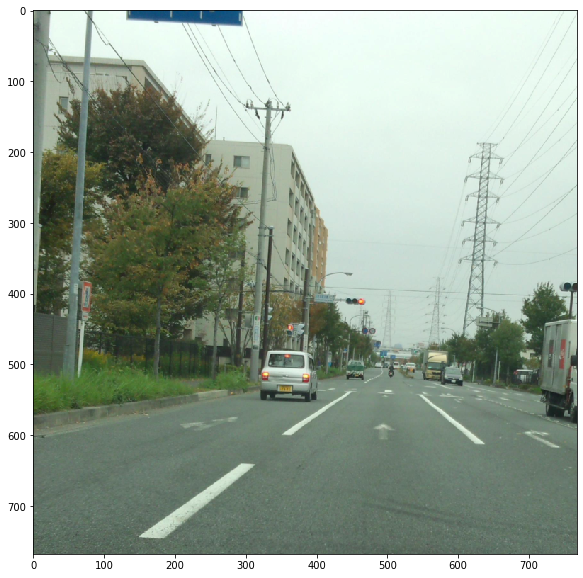

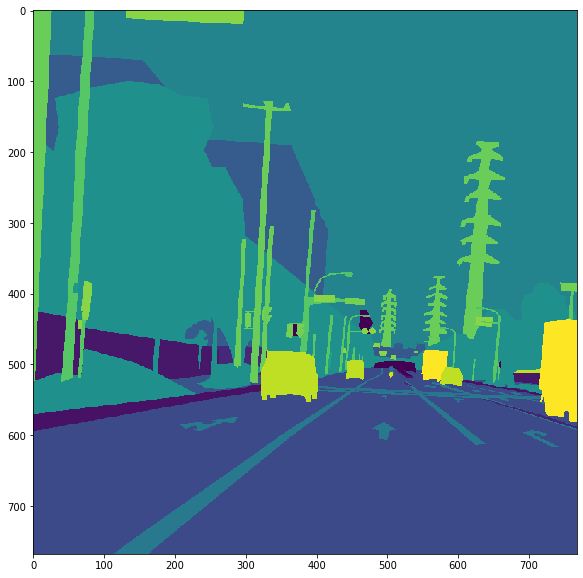

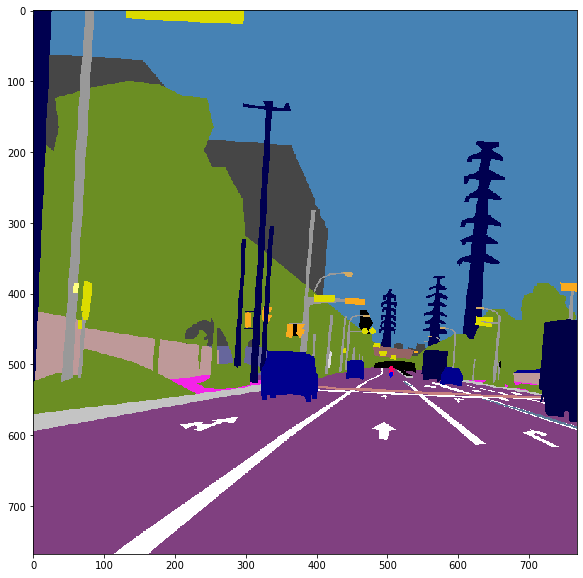

In [4]:
image, label = testset[0]
std = np.asarray([.229, .224, .225])
std = std[:,np.newaxis]
std = std[:,np.newaxis]
print(std.shape)

mean = np.asarray([.485, .456, .406])
mean = mean[:,np.newaxis]
mean = mean[:,np.newaxis]

print(std.shape)

plt.figure(figsize=(10,10))
plt.imshow(np.transpose(image.numpy() * std + mean, [1,2,0]) )
plt.show()


plt.figure(figsize=(10,10))
plt.imshow(label)
plt.show()

mask = testset.apply_color_map(label.cpu().numpy())
plt.figure(figsize=(10,10))
plt.imshow(mask)
plt.show()

In [12]:
def _make_one_hot(labels,num_class,):
    '''
    Converts an integer label torch.autograd.Variable to a one-hot Variable.

    Parameters
    ----------
    labels : torch.autograd.Variable of torch.cuda.LongTensor
        N x 1 x H x W, where N is batch size.
        Each value is an integer representing correct classification.
    C : integer.
        number of classes in labels.

    Returns
    -------
    target : torch.autograd.Variable of torch.cuda.FloatTensor
        N x C x H x W, where C is class number. One-hot encoded.
    '''
    one_hot = torch.zeros((labels.shape[0], num_class + 1, labels.shape[1], labels.shape[2])).type_as(labels)

    target = one_hot.scatter_(1, (labels+1).unsqueeze(1).data, 1)
    target = target[:,1:,:,:]
    return target



torch.Size([1, 768, 768])


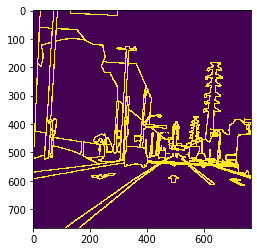

In [23]:
import torch.nn.functional as F
print(label.unsqueeze(0).shape)
label_one_hot = _make_one_hot(label.unsqueeze(0), 65)
label_one_hot = label_one_hot.float()
label_one_hot_edges = F.max_pool2d(label_one_hot,(5,5),1,1)
edges = torch.sum(label_one_hot_edges,dim=1) > 1
#print(edges.squeeze(0))
plt.imshow(edges.squeeze(0))
plt.show()

In [8]:
from torch.autograd import Variable

def _class_balanced_weights(target, nclass , beta=1-1e-2):
    # target is a 3D Variable BxHxW, output is 2D BxnClass
    batch = target.size(0)
    tvect = torch.zeros(batch, nclass)
    for i in range(batch):
        hist = torch.histc(target[i].cpu().data.float(), 
                           bins=nclass, min=0,
                           max=nclass-1)
        #vect = hist>0
        tvect[i] = hist
    tvect_sum = torch.sum(tvect,0)
    tvect_sum = (1 - beta)/(1-beta**(tvect_sum))
    tvect_sum[tvect_sum==np.inf] = 0    
    return tvect_sum
    


tensor([0.0000e+00, 0.0000e+00, 1.4653e-04, 5.6356e-05, 0.0000e+00, 3.9485e-03,
        3.6971e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0887e-05, 0.0000e+00, 2.6749e-03, 4.8856e-03, 1.9152e-05,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 4.4859e-02, 0.0000e+00, 2.7804e-03,
        2.4424e-04, 0.0000e+00, 0.0000e+00, 8.3895e-06, 0.0000e+00, 1.0966e-01,
        1.6437e-05, 0.0000e+00, 2.9026e-02, 0.0000e+00, 0.0000e+00, 3.3689e-03,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 3.0094e-03, 1.1351e-04, 0.0000e+00, 5.9399e-05,
        2.2904e-03, 7.8325e-03, 1.7468e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 4.8882e-04, 0.0000e+00, 8.2241e-02, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.2806e-04, 0.0000e+00, 0.0000e+00, 5.9338e-06])


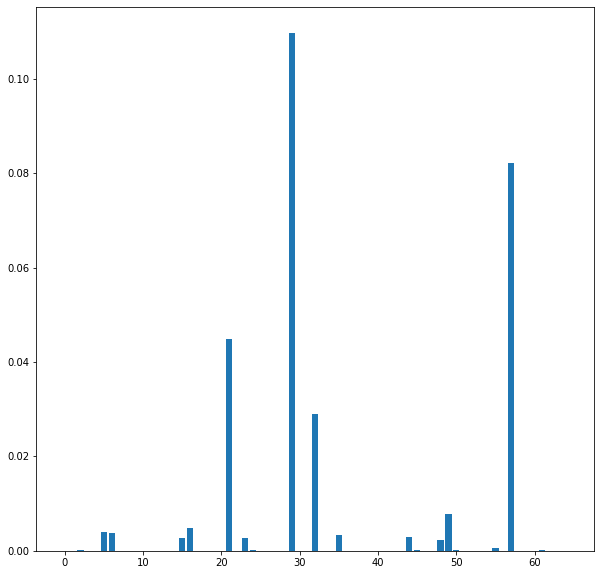

In [14]:
out  = _class_balanced_weights(label.unsqueeze(0), 65,0.999999)

print(out)
plt.figure(figsize=(10,10))
plt.bar(range(65), out.cpu().numpy().flatten())
plt.show()

# plt.figure(figsize=(10,10))
# plt.bar(range(65), (out.cpu().numpy().flatten())/max(out.cpu().numpy().flatten()))
# plt.show()

# beta = 1 - 1e-1
# out2 = ((1 - beta)/(1-beta**(out.cpu().numpy().flatten())))

# plt.figure(figsize=(10,10))
# plt.bar(range(65), out2)
# plt.show()
